In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import os

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [79]:
# Define transformations for grayscale and color images
transform_gray = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor()  # Convert images to tensors
])

def list_files_in_directory(directory):
    files = os.listdir(directory)
    return files

train_files = list_files_in_directory("train")
test_files = list_files_in_directory("test")
validation_files = list_files_in_directory("validation")


In [80]:
def process_dataset(original_data):
    gray_data = []
    for image in original_data:
        image_resized_gray = transform_gray(image)

        # Append the grayscale and HSV images to their respective lists
        gray_data.append(image_resized_gray)
    return gray_data


In [81]:
def read_images_from_directory(directory):
    images = []
    files = os.listdir(directory)
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            file_path = os.path.join(directory, file)
            image = Image.open(file_path)
            images.append(image)
    return images

# Example usage
train_data      = read_images_from_directory("train")
test_data       = read_images_from_directory("test")
validation_data = read_images_from_directory("validation")

In [82]:
gray_data_train      = process_dataset(train_data)
gray_data_test       = process_dataset(test_data)
gray_data_validation = process_dataset(validation_data)

In [83]:
print("Size of grayscale dataset:", len(gray_data_train))
gray_image_shape  = gray_data_train[0][0].shape
print("Shape of the first grayscale image tensor:", gray_image_shape)
gray_image_shape  = gray_data_train[0].shape
print("Shape of the first grayscale image tensor:", gray_image_shape)

Size of grayscale dataset: 70
Shape of the first grayscale image tensor: torch.Size([128, 128])
Shape of the first grayscale image tensor: torch.Size([1, 128, 128])


In [84]:
def normalize_and_scale(images):
    mean = torch.mean(images)
    var = torch.var(images)
    normalized_images = (images - mean) / torch.sqrt(var)
    scaled_images = normalized_images / 2 +0.5
    return scaled_images

In [85]:
gray_images_train  = torch.stack(gray_data_train)
gray_images_test   = torch.stack(gray_data_test)
gray_images_val    = torch.stack(gray_data_validation)

gray_images_train_normalized  = normalize_and_scale(gray_images_train)
gray_images_test_normalized   = normalize_and_scale(gray_images_test)
gray_images_val_normalized    = normalize_and_scale(gray_images_val)

# Create datasets
dataset_train = TensorDataset(gray_images_train, gray_images_train)
dataset_test  = TensorDataset(gray_images_test, gray_images_test)
dataset_val   = TensorDataset(gray_images_val, gray_images_val)

# Create data loaders
batch_size = 20
train_loader = DataLoader(dataset_train, batch_size=batch_size       , shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=len(dataset_val) , shuffle=False)
test_loader  = DataLoader(dataset_test,  batch_size=len(dataset_test), shuffle=False)

In [86]:
for batch_idx, (inputs_gray, targets_color) in enumerate(train_loader):
    print("Batch Index:", batch_idx)
    print("Shape of inputs (grayscale images):", inputs_gray.shape)
    print("Shape of targets (color images):"   , targets_color.shape)
    break  # Print only the first batch

Batch Index: 0
Shape of inputs (grayscale images): torch.Size([20, 1, 128, 128])
Shape of targets (color images): torch.Size([20, 1, 128, 128])


In [87]:
for batch_idx, (inputs_gray, targets_color) in enumerate(val_loader):
    print("Batch Index:", batch_idx)
    print("Shape of inputs (grayscale images):", inputs_gray.shape)
    print("Shape of targets (color images):"   , targets_color.shape)
    break  # Print only the first batch

Batch Index: 0
Shape of inputs (grayscale images): torch.Size([70, 1, 128, 128])
Shape of targets (color images): torch.Size([70, 1, 128, 128])


In [88]:
def plot_image_and_histogram(loader):
    # Get a batch of data
    data_iter = iter(loader)
    gray_images, color_images = next(data_iter)
    
    # Plot grayscale image and histogram
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(gray_images[0].squeeze(), cmap='gray')  # Squeeze to remove the channel dimension if it exists
    plt.title('Grayscale Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.hist(gray_images[0].numpy().flatten(), bins=256, color='blue', alpha=0.7)
    plt.title('Grayscale Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.show()

    # Plot color image and histograms for each channel
    plt.figure(figsize=(20, 4))  # Adjust the figure size
    plt.show()

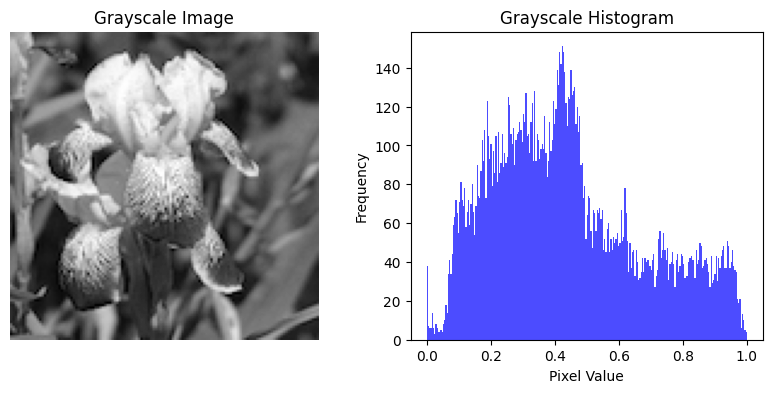

<Figure size 2000x400 with 0 Axes>

In [89]:
# display_random_image(coder_loader)
plot_image_and_histogram(val_loader)

In [90]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        
        # Decoder
        x = self.decoder(x)
        
        return x

In [91]:
# Assuming 'ColorizationModel' is already defined and imported
model_encoder_decoder = ColorizationModel()

# Assuming 'coder_loader' is properly set with appropriate DataLoader
x, y = next(iter(train_loader))
print(f"Input shape: {x.shape}")  # Should print the shape of x, typically (batch_size, channels, H, W)

# Feed the input through the model
yHat = model_encoder_decoder(x)
print(f"Output shape before CUDA: {yHat.shape}")  # Should match the expected output shape

# Move the model to CUDA
model_encoder_decoder = model_encoder_decoder.cuda()  # Ensure you have a CUDA device available

# You might need to move 'x' to CUDA if not done automatically by your dataloader
x = x.cuda()  # Uncomment this if your dataloader doesn't handle device transfer
yHat = model_encoder_decoder(x)
print(f"Output shape after CUDA: {yHat.shape}")
print(f"Target shape: {y.shape}")

# Print model summary for input size (1, 128, 128)
summary(model_encoder_decoder, (1, 128, 128))

Input shape: torch.Size([20, 1, 128, 128])
Output shape before CUDA: torch.Size([20, 1, 128, 128])
Output shape after CUDA: torch.Size([20, 1, 128, 128])
Target shape: torch.Size([20, 1, 128, 128])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         LeakyReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
       BatchNorm2d-5           [-1, 32, 64, 64]              64
         LeakyReLU-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
       BatchNorm2d-8           [-1, 64, 32, 32]             128
         LeakyReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
      BatchNorm2d-11          [-1

In [92]:
def visualize_encoder(model, test_loader):
    model.eval()
    with torch.no_grad():
        # Get one batch of data
        grayscale_image, _ = next(iter(test_loader))

        # Generate colorized image
        colorized_image = model(grayscale_image)

        # Remove batch dimension
        grayscale_image = grayscale_image[0]
        colorized_image = colorized_image[0]
        
        # Convert tensors to numpy arrays for visualization
        grayscale_image_np = grayscale_image[0].numpy()#+0.5
        colorized_image_np = colorized_image[0].numpy()#+0.5
        # Plot the original grayscale and colorized images
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(grayscale_image_np, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(colorized_image_np, cmap='gray')
        plt.title('Grayscale Image\n from the coder')
        plt.axis('off')

        # Save the figure
        plt.show()

In [93]:
class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = self.create_window(window_size, self.channel)

    def create_window(self, window_size, channel):
        # Ensure all operations are on tensors
        _1D_window = torch.Tensor([0.5 * (1.0 + torch.cos(2 * torch.tensor(3.141592653589793) * torch.tensor(x / (window_size - 1) - 0.5))) for x in range(window_size)])
        _1D_window = _1D_window / _1D_window.sum()
        _2D_window = _1D_window.unsqueeze(1).mm(_1D_window.unsqueeze(0)).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
        return window

    def ssim(self, img1, img2):
        (_, channel, _, _) = img1.size()
        window = self.window.type_as(img1)

        mu1 = F.conv2d(img1, window, padding=self.window_size // 2, groups=channel)
        mu2 = F.conv2d(img2, window, padding=self.window_size // 2, groups=channel)

        mu1_sq = mu1 ** 2
        mu2_sq = mu2 ** 2
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=self.window_size // 2, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=self.window_size // 2, groups=channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=self.window_size // 2, groups=channel) - mu1_mu2

        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

        if self.size_average:
            return ssim_map.mean()
        else:
            return ssim_map.mean(1).mean(1).mean(1)

    def forward(self, img1, img2):
        return 1 - self.ssim(img1, img2)

In [94]:
def train_model(model, coder_loader, val_loader, optimizer, epochs, loss_functions):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Transfer the model to the GPU if available
    
    train_losses = []
    val_losses = []
    current_loss_index = 0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        # Change the loss function every 10 epochs
        if (epoch - 1) % 20 == 0:
            criterion = loss_functions[current_loss_index % len(loss_functions)].to(device)
            current_loss_index += 1
            print(f"Using {criterion.__class__.__name__} as the loss function.")

        # Training loop
        for images, labels in coder_loader:
            images = images.to(device)  # Transfer images to the GPU if available
            labels = labels.to(device)  # Transfer labels to the GPU if available
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Calculate average training loss
        train_loss = running_loss / len(coder_loader.dataset)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)  # Transfer images to the GPU if available
                labels = images.to(device)  # Transfer labels to the GPU if available
                outputs = model(images)
                val_loss += criterion(outputs, labels).item() * images.size(0)

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print epoch statistics
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            model.to('cpu')
            visualize_encoder(model, train_loader)
            model.to(device)

    return train_losses, val_losses, model.encoder, model

Using MSELoss as the loss function.
Epoch 5/200, Train Loss: 0.0122, Val Loss: 0.0287


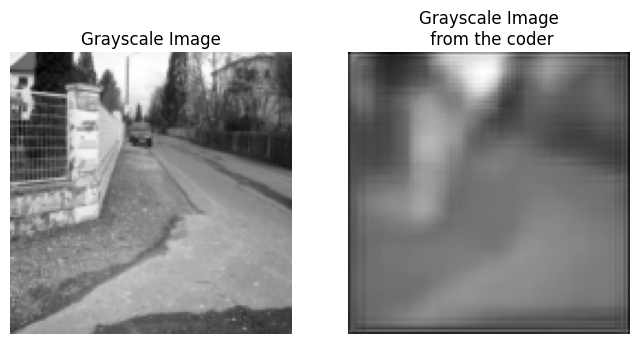

Epoch 10/200, Train Loss: 0.0087, Val Loss: 0.0110


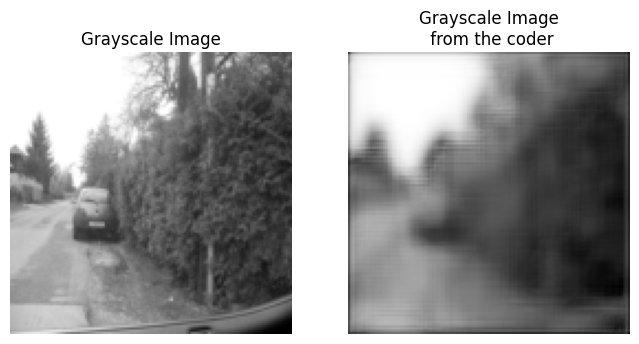

Epoch 15/200, Train Loss: 0.0070, Val Loss: 0.0071


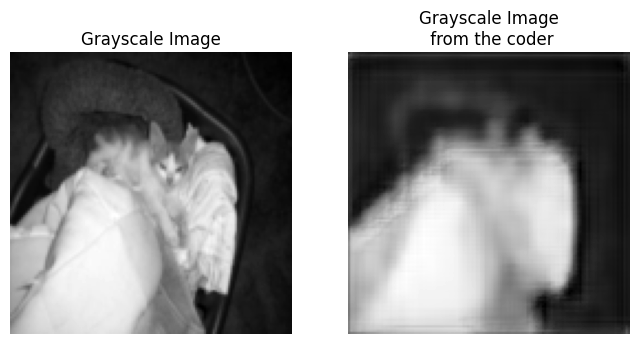

Epoch 20/200, Train Loss: 0.0077, Val Loss: 0.0073


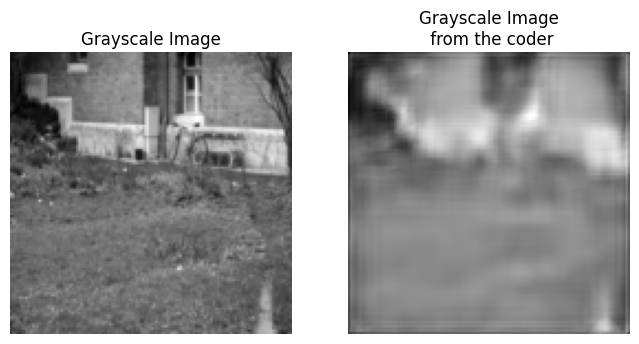

Using SSIMLoss as the loss function.
Epoch 25/200, Train Loss: 0.2809, Val Loss: 0.2928


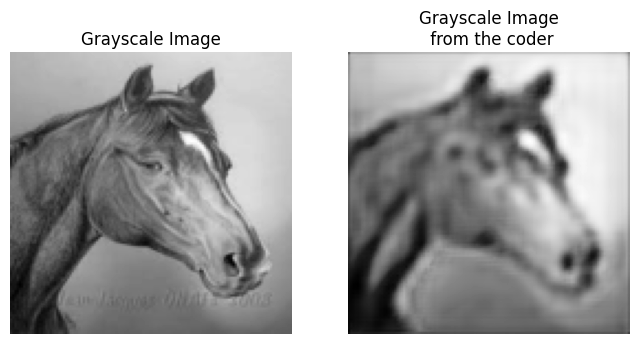

Epoch 30/200, Train Loss: 0.2339, Val Loss: 0.2398


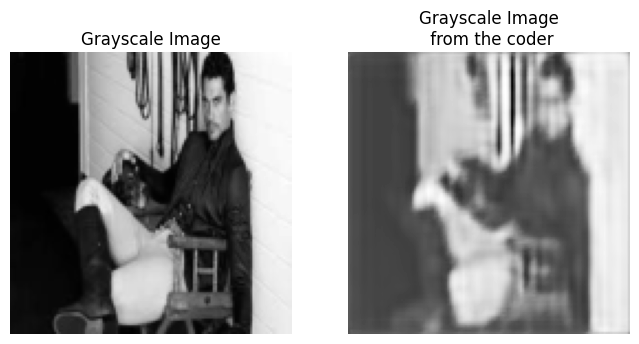

Epoch 35/200, Train Loss: 0.1947, Val Loss: 0.2110


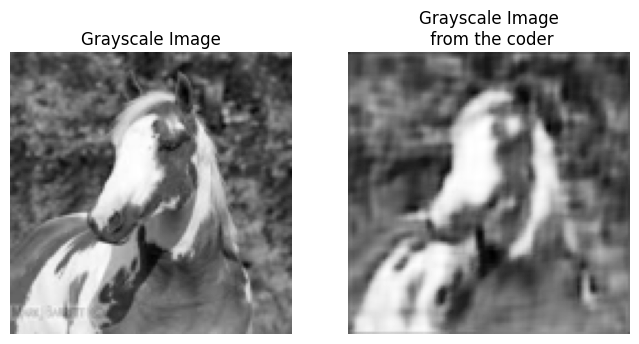

Epoch 40/200, Train Loss: 0.1767, Val Loss: 0.2097


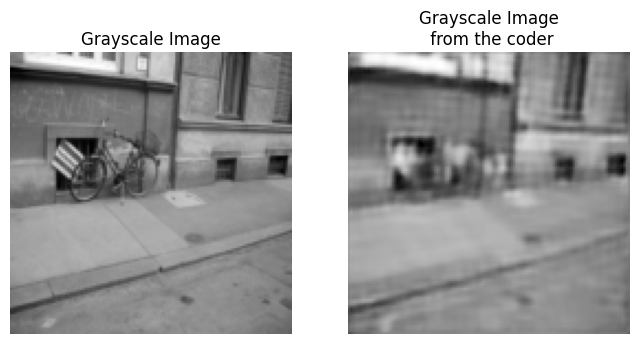

Using L1Loss as the loss function.
Epoch 45/200, Train Loss: 0.0476, Val Loss: 0.0447


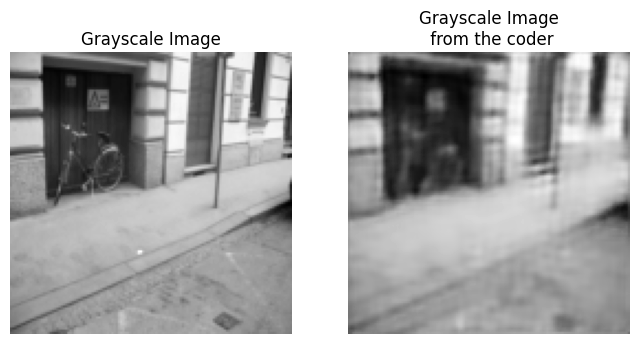

Epoch 50/200, Train Loss: 0.0533, Val Loss: 0.0540


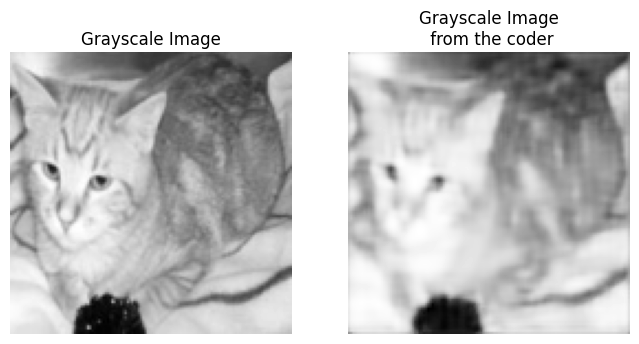

Epoch 55/200, Train Loss: 0.0466, Val Loss: 0.0544


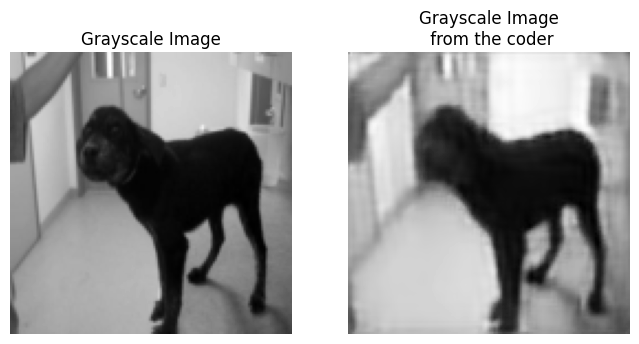

Epoch 60/200, Train Loss: 0.0507, Val Loss: 0.0349


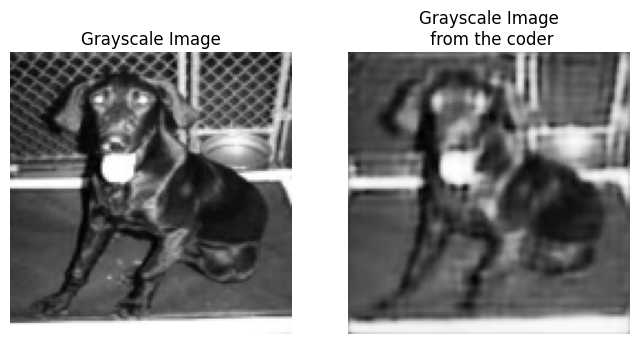

Using MSELoss as the loss function.
Epoch 65/200, Train Loss: 0.0032, Val Loss: 0.0032


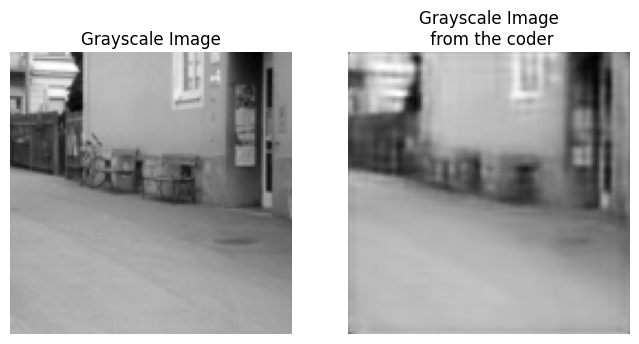

Epoch 70/200, Train Loss: 0.0037, Val Loss: 0.0029


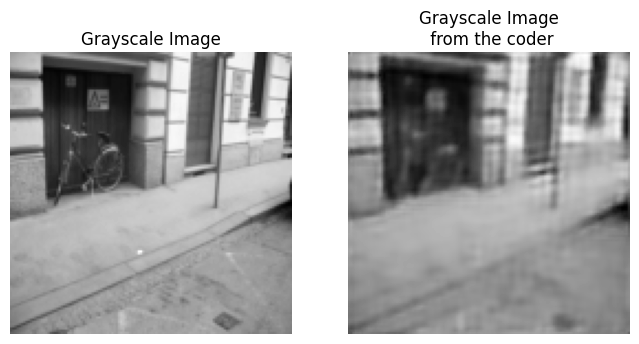

Epoch 75/200, Train Loss: 0.0034, Val Loss: 0.0027


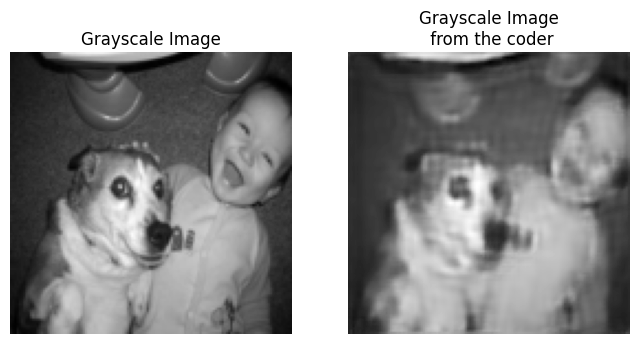

Epoch 80/200, Train Loss: 0.0030, Val Loss: 0.0027


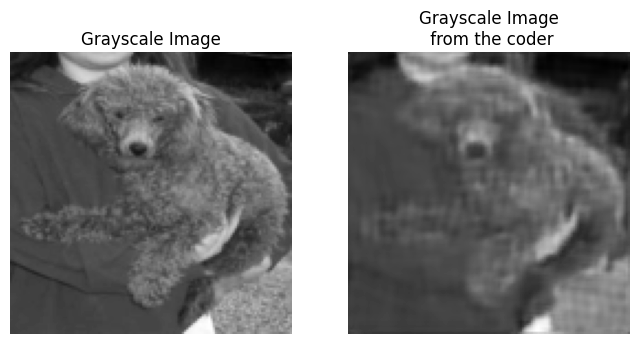

Using SSIMLoss as the loss function.
Epoch 85/200, Train Loss: 0.1702, Val Loss: 0.2131


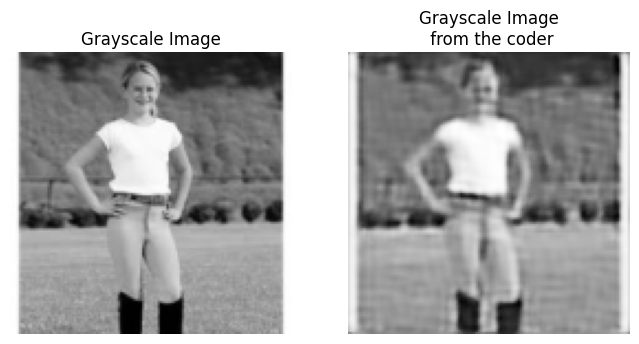

Epoch 90/200, Train Loss: 0.1525, Val Loss: 0.1723


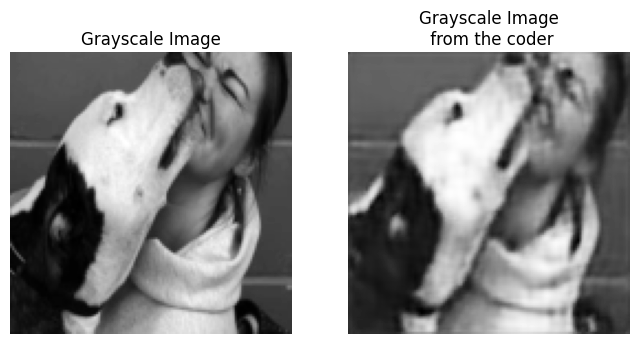

Epoch 95/200, Train Loss: 0.1497, Val Loss: 0.1647


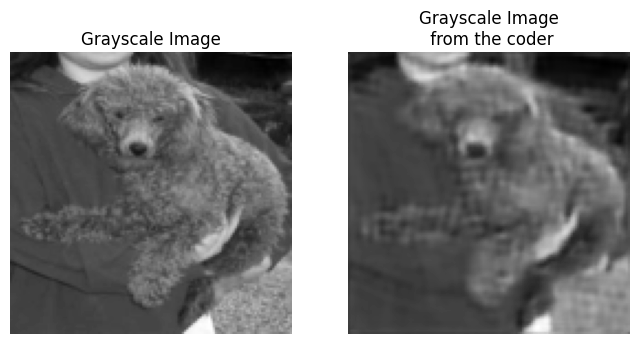

Epoch 100/200, Train Loss: 0.1391, Val Loss: 0.1701


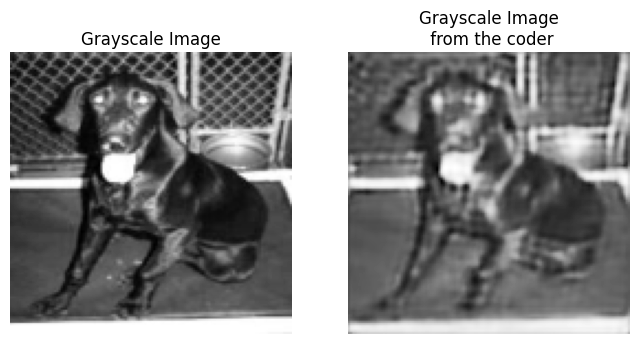

Using L1Loss as the loss function.
Epoch 105/200, Train Loss: 0.0386, Val Loss: 0.0396


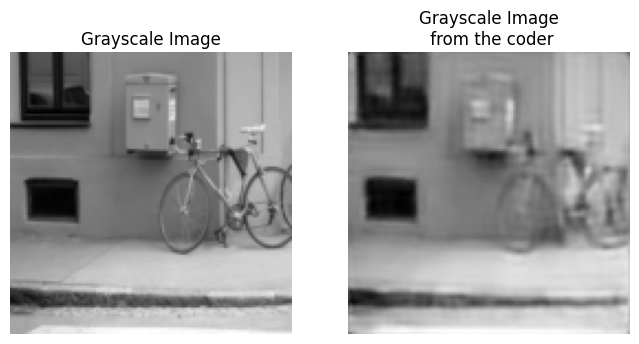

Epoch 110/200, Train Loss: 0.0451, Val Loss: 0.0564


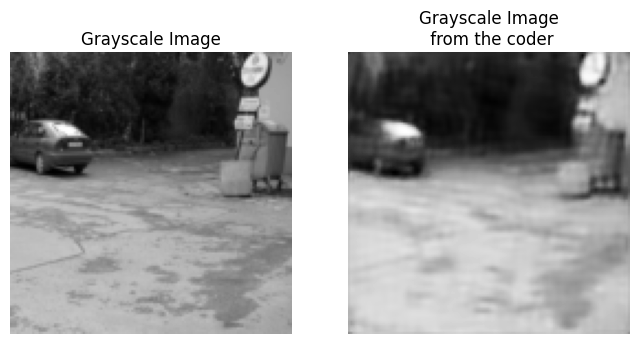

Epoch 115/200, Train Loss: 0.0400, Val Loss: 0.0395


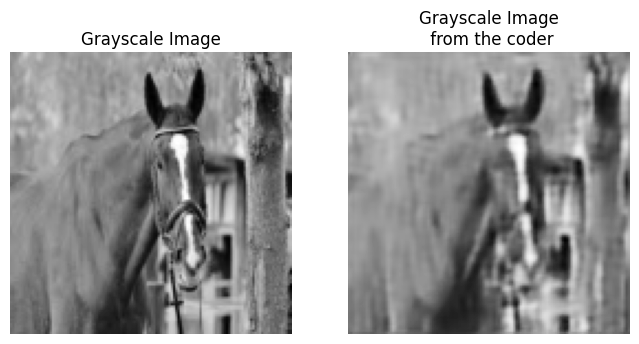

Epoch 120/200, Train Loss: 0.0394, Val Loss: 0.0345


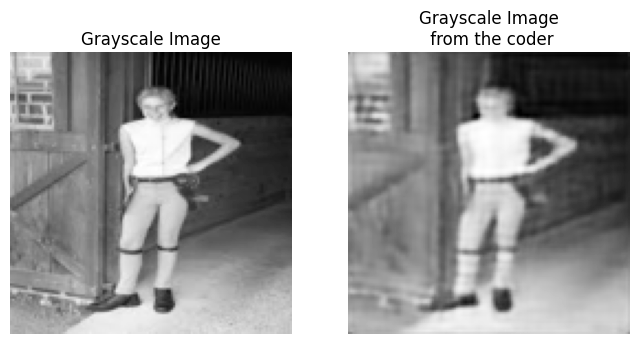

Using MSELoss as the loss function.
Epoch 125/200, Train Loss: 0.0024, Val Loss: 0.0024


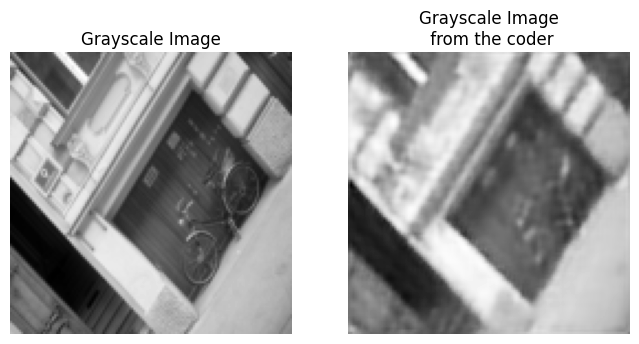

Epoch 130/200, Train Loss: 0.0027, Val Loss: 0.0023


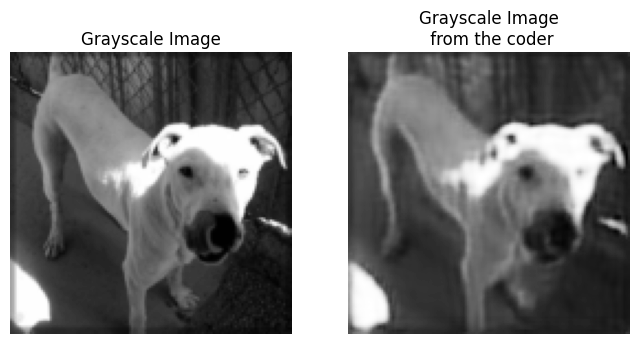

Epoch 135/200, Train Loss: 0.0021, Val Loss: 0.0022


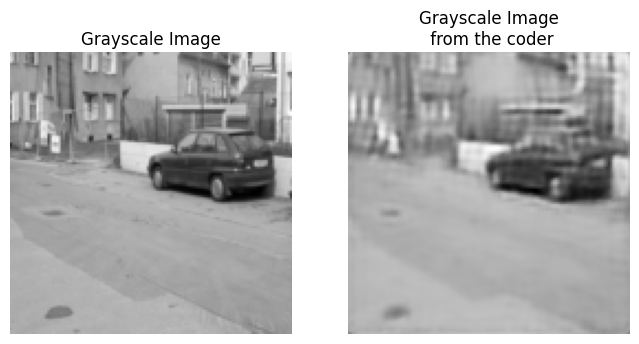

Epoch 140/200, Train Loss: 0.0022, Val Loss: 0.0022


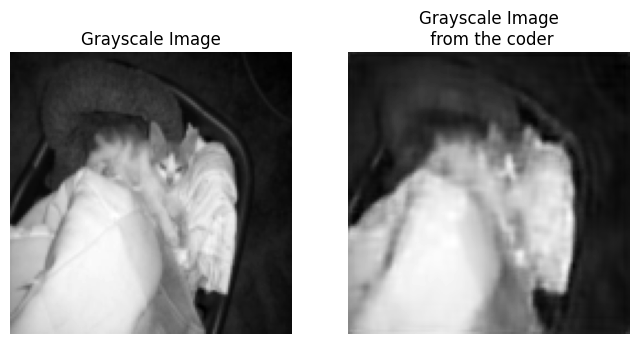

Using SSIMLoss as the loss function.
Epoch 145/200, Train Loss: 0.1615, Val Loss: 0.2074


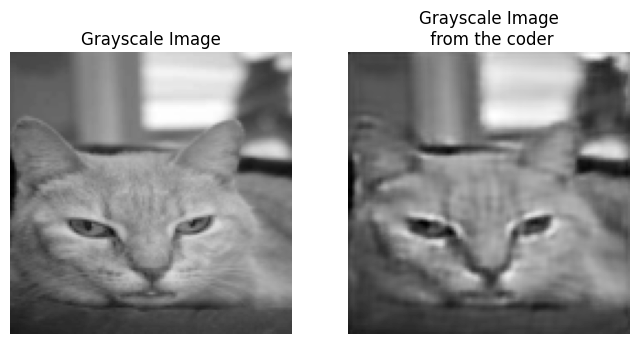

Epoch 150/200, Train Loss: 0.1495, Val Loss: 0.1696


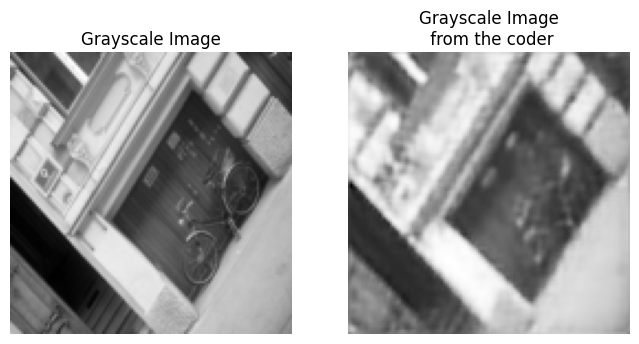

Epoch 155/200, Train Loss: 0.1249, Val Loss: 0.1587


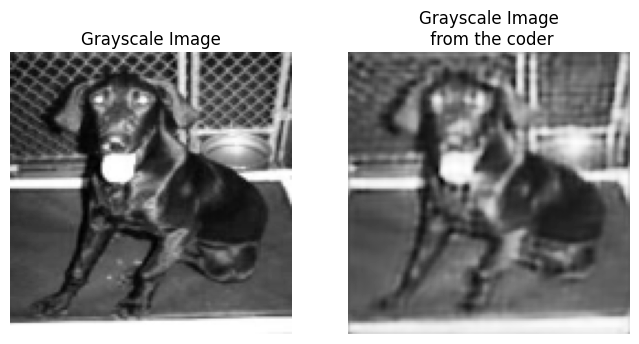

Epoch 160/200, Train Loss: 0.1181, Val Loss: 0.1417


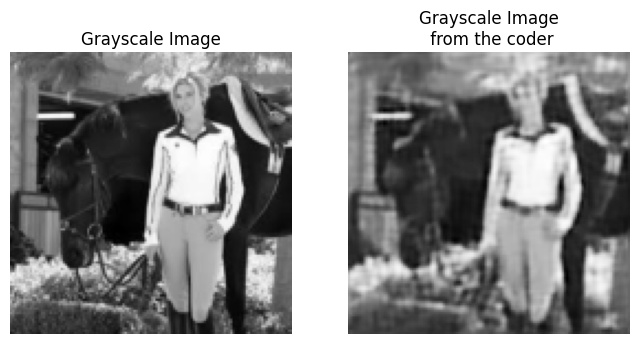

Using L1Loss as the loss function.
Epoch 165/200, Train Loss: 0.0510, Val Loss: 0.0450


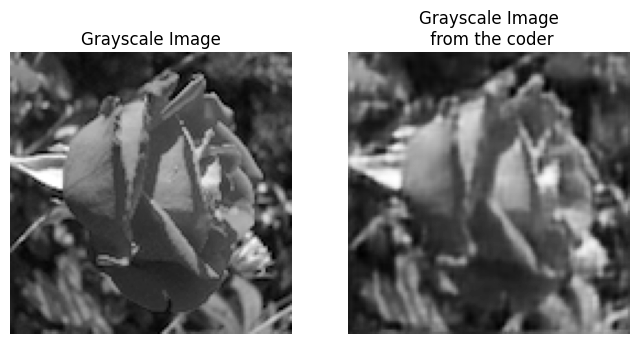

Epoch 170/200, Train Loss: 0.0377, Val Loss: 0.0381


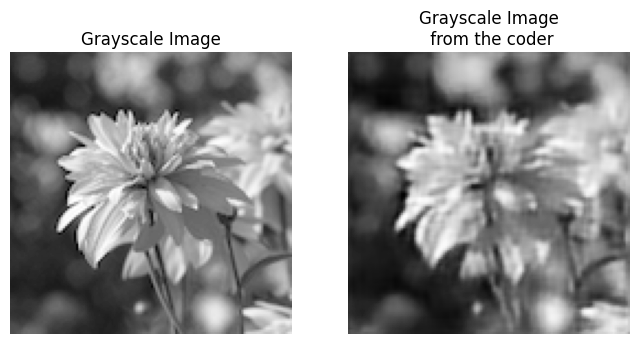

Epoch 175/200, Train Loss: 0.0422, Val Loss: 0.0344


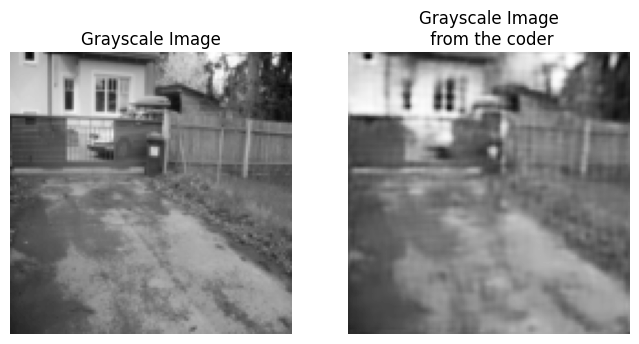

Epoch 180/200, Train Loss: 0.0405, Val Loss: 0.0320


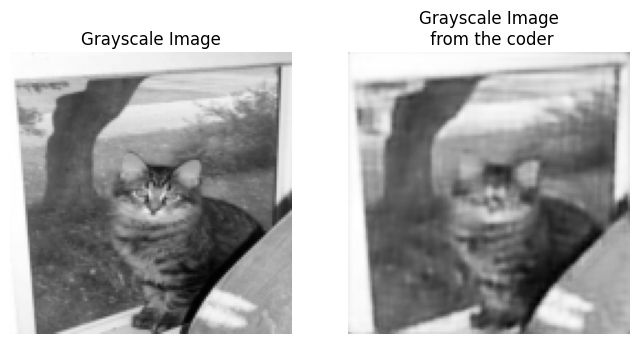

Using MSELoss as the loss function.
Epoch 185/200, Train Loss: 0.0026, Val Loss: 0.0022


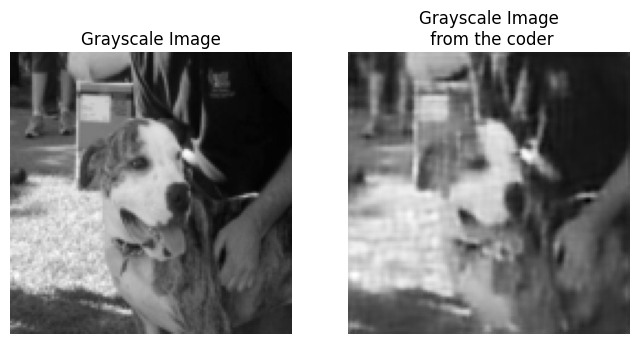

Epoch 190/200, Train Loss: 0.0024, Val Loss: 0.0021


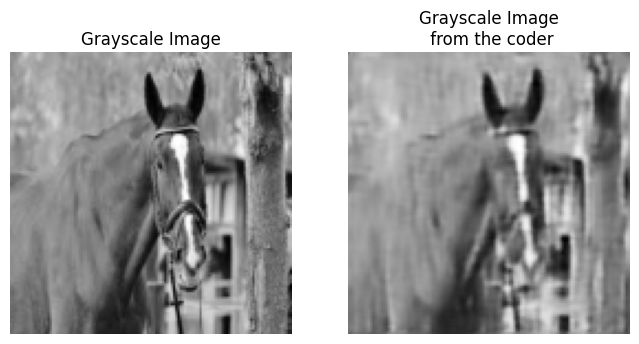

Epoch 195/200, Train Loss: 0.0025, Val Loss: 0.0021


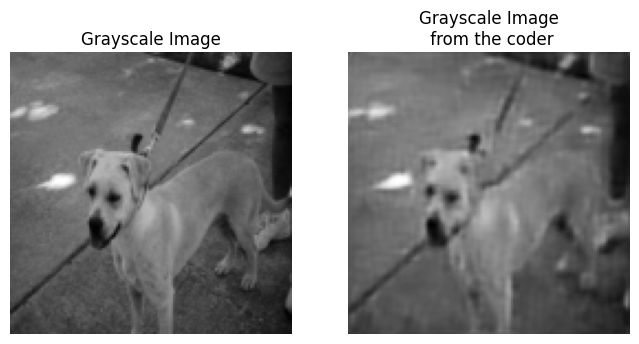

Epoch 200/200, Train Loss: 0.0024, Val Loss: 0.0020


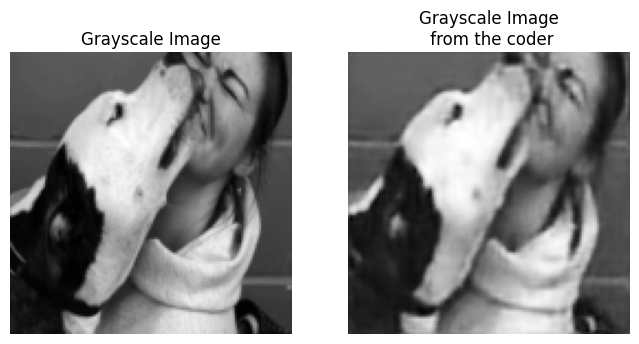

In [95]:
loss_functions = [nn.MSELoss(), SSIMLoss(window_size=11, size_average=True),nn.L1Loss()]
# Example usage
optimizer = torch.optim.Adam(model_encoder_decoder.parameters(), lr=0.001)
epochs = 200
# Train the model
train_losses, val_losses, model_encoder_trained, model = train_model(model_encoder_decoder, train_loader, val_loader, optimizer, epochs, loss_functions)

In [96]:
def plot_losses(train_losses_list, val_losses_list):
    plt.figure(figsize=(10, 6))

    # Plot training losses
    if isinstance(train_losses_list[0], list):
        for i, train_losses in enumerate(train_losses_list):
            plt.plot(range(1, len(train_losses) + 1), train_losses, label=f"Model {i+1} - Train Loss")
    else:
        plt.plot(range(1, len(train_losses_list) + 1), train_losses_list, label="Train Loss")

    # Plot validation losses
    if isinstance(val_losses_list[0], list):
        for i, val_losses in enumerate(val_losses_list):
            plt.plot(range(1, len(val_losses) + 1), val_losses, label=f"Model {i+1} - Validation Loss", linestyle='--')
    else:
        plt.plot(range(1, len(val_losses_list) + 1), val_losses_list, label="Validation Loss", linestyle='--')

    plt.title("Train and Validation Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

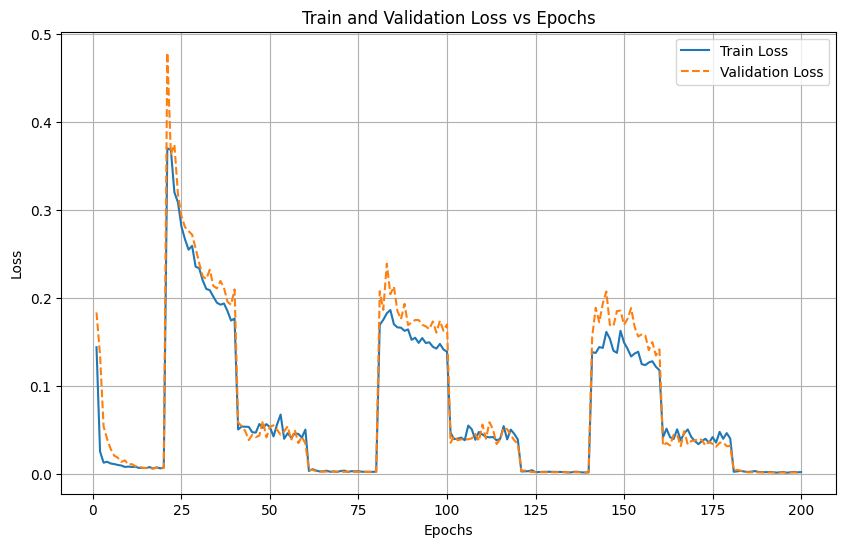

In [97]:
plot_losses(train_losses, val_losses)

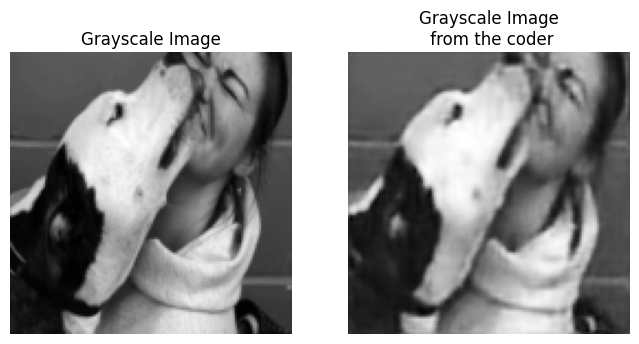

In [98]:
model.to('cpu')
visualize_encoder(model, train_loader)

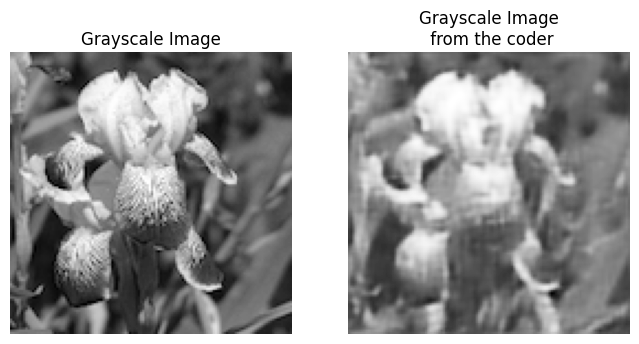

In [99]:
visualize_encoder(model, val_loader)

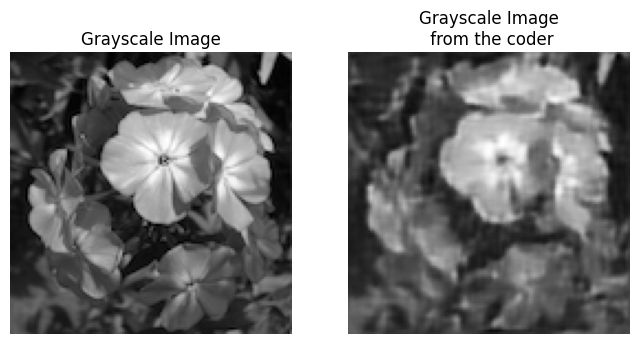

In [100]:
visualize_encoder(model, test_loader)

In [101]:
torch.save(model_encoder_trained.state_dict(), 'model_encoder_trained.pth')